In [5]:
# import our libraries
import os
import requests, zipfile, io
import urllib
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook, tqdm
import multiprocessing as mp
from datetime import datetime
import time
import csv
import itertools
import matplotlib
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import argparse
from termcolor import colored

In [2]:
"""List of arguments to be received"""
"""
ap = argparse.ArgumentParser()
ap.add_argument("-tr", "--time_range", type=str, required=True, help="Temporal range of the data to download")
args = vars(ap.parse_args())
time_range = args["time_range"]
"""
# Specify the start and finish of the data collection
# The range is specified in QTR (1 to 4 each year)
# The range is inclusive of the min the max

time_range = [(2018, 1), (2018, 4)]

In [3]:
"""Set up the working path"""
home = os.path.expanduser("~")
project_root = os.path.join(home, 'Desktop/data')

path_master_indexes = os.path.join(project_root, 'master_indexes')
path_daily_data = os.path.join(project_root, 'daily_data')
path_error_log = os.path.join(project_root, 'errors.log')
path_download_status_log = os.path.join(project_root, 'download_status.log')
base_url = "https://www.sec.gov/Archives/"

# Check that the folder structure exists and we have the permission to write on it
def test_setup_work_directory():
    # Build the directory architecture if it does not exist yet
    if not os.path.isdir(project_root):
        os.makedirs(project_root)
    path_temp_file = os.path.join(project_root, 'temp_test_setup_work_directory.temp')
    with open(path_temp_file, 'w') as f:
        pass
    os.remove(path_temp_file)
    return True

test_setup_work_directory()

True

In [4]:
verbose = False

## Set the parameters of interest

### Documents of interests

In [5]:
doc_types = [
    '10-K',
    '10-Q',
]

In [6]:
info = {}

## Create the list of master indexes to download

In [7]:
def create_qtr_list(time_range):
    # Sanity checks
    assert len(time_range) == 2
    assert 1994 <= time_range[0][0] and 1994 <= time_range[1][0]
    assert 1 <= time_range[0][1] <= 4 and 1 <= time_range[1][1] <= 4
    assert time_range[1][0] >= time_range[0][0]
    if time_range[1][0] == time_range[0][0]:  # Same year
        assert time_range[1][1] >= time_range[0][1]  # Need different QTR
    
    list_qtr = []
    for year in range(time_range[0][0], time_range[1][0]+1):
        for qtr in range(1, 5):
            # Manage the start and end within a year
            if year == time_range[0][0]:
                if qtr < time_range[0][1]:
                    continue
            if year == time_range[1][0]:
                if qtr > time_range[1][1]:
                    break
            
            # Common case
            list_qtr.append((year, qtr))
    
    # Sanity checks
    assert list_qtr[0] == time_range[0]
    assert list_qtr[-1] == time_range[1]
    return list_qtr

def test_create_qtr_list():
    test_1 = create_qtr_list([(2018, 1), (2018, 4)])
    assert test_1 == [(2018, 1), (2018, 2), (2018, 3), (2018, 4)]
    test_2 = create_qtr_list([(2016, 2), (2017, 3)])
    assert test_2 == [(2016, 2), (2016, 3), (2016, 4), (2017, 1), (2017, 2), (2017, 3)]
    return True
test_create_qtr_list()

True

In [8]:
info['quarters'] = create_qtr_list(time_range)
info['quarters']

[(2018, 1), (2018, 2), (2018, 3), (2018, 4)]

In [9]:
def yearly_qtr_list(time_range):
    year_list = []
    if time_range[0][0] == time_range[1][0]:
        year_list = create_qtr_list(time_range)
    else:
        for year in range(time_range[0][0], time_range[1][0]+1):
            if year == time_range[0][0]:
                year_list.append(create_qtr_list([(year, time_range[0][1]), (year, 4)]))
            elif year == time_range[1][0]:
                year_list.append(create_qtr_list([(year, 1), (year, time_range[1][1])]))
            else:
                year_list.append(create_qtr_list([(year, 1), (year, 4)]))
    return year_list

def test_yearly_qtr_list():
    test_1 = yearly_qtr_list([(2016, 2), (2016, 2)])
    assert test_1 == [(2016, 2)]
    test_2 = yearly_qtr_list([(2015, 2), (2016, 3)])
    assert test_2 == [[(2015, 2), (2015, 3), (2015, 4)], [(2016, 1), (2016, 2), (2016, 3)]]
    return True
test_yearly_qtr_list()

True

In [10]:
# Build the URL for the master index of a given quarter
def qtr_to_master_url(qtr):
    assert type(qtr) == tuple
    url = r"https://www.sec.gov/Archives/edgar/full-index"
    return '{}/{}/QTR{}/master.zip'.format(url, qtr[0], qtr[1])

In [11]:
def master_url_to_filepath(url):
    qtr = url.split('/')
    return os.path.join(path_master_indexes, qtr[6], qtr[7], 'master.zip')

In [12]:
def create_list_url_master_zip(list_qtr):
    # Sanity checks
    assert len(list_qtr)
    
    list_master_idx = []
    for qtr in list_qtr:
        list_master_idx.append(qtr_to_master_url(qtr))
    return list_master_idx

In [13]:
info['url_master_zip'] = create_list_url_master_zip(info['quarters'])
info['url_master_zip']

['https://www.sec.gov/Archives/edgar/full-index/2018/QTR1/master.zip',
 'https://www.sec.gov/Archives/edgar/full-index/2018/QTR2/master.zip',
 'https://www.sec.gov/Archives/edgar/full-index/2018/QTR3/master.zip',
 'https://www.sec.gov/Archives/edgar/full-index/2018/QTR4/master.zip']

## Download all the master indexes as zip files

In [14]:
def is_downloaded(filepath):
    #expected_path = master_url_to_filepath(url_idx)
    if os.path.isfile(filepath):
        return True
    else:  # Build the folder architecture if needed
        if not os.path.isdir(os.path.split(filepath)[0]):
            os.makedirs(os.path.split(filepath)[0])
        return False

def test_is_downloaded():
    test_1 = is_downloaded("/ahsbxaksjhbxhjx.txt")
    assert test_1 == False
    path_temp_file = os.path.join(home, "temp_test_is_downloaded.temp")
    with open(path_temp_file, 'w') as f:
        pass
    test_2 = is_downloaded(path_temp_file)
    os.remove(path_temp_file)
    assert test_2 == True
    return True
test_is_downloaded()

True

In [15]:
info['path_master_zip'] = []
for url in info['url_master_zip']:
    info['path_master_zip'].append(master_url_to_filepath(url))
info['path_master_zip']  # list of all the zips we need

['/home/alex/Desktop/data/master_indexes/2018/QTR1/master.zip',
 '/home/alex/Desktop/data/master_indexes/2018/QTR2/master.zip',
 '/home/alex/Desktop/data/master_indexes/2018/QTR3/master.zip',
 '/home/alex/Desktop/data/master_indexes/2018/QTR4/master.zip']

def is_downloaded(url_idx):
    expected_path = master_url_to_filepath(url_idx)
    if os.path.isfile(expected_path):
        return True
    else:  # Build the folder architecture if needed
        if not os.path.isdir(os.path.split(expected_path)[0]):
            os.makedirs(os.path.split(expected_path)[0])
        return False

In [16]:
"""Verify that the master index zip are present. If not, download it."""
download_stats = {
    'bytes_downloaded': 0,
    'count_downloaded': 0
}  # Number of files, bytes

for n, filepath in enumerate(tqdm(info['path_master_zip'])):
    # Check if that zip has already been downloaded
    # print(filepath, is_downloaded(filepath))
    # assert 0
    if not is_downloaded(filepath):
        #raw_idx = requests.get(url_idx)
        (filename, headers) = urllib.request.urlretrieve(info['url_master_zip'][n], filepath)
        if verbose:
            print(filename, headers)
        download_stats['bytes_downloaded'] += os.path.getsize(filepath)
        download_stats['count_downloaded'] += 1
    else:
        if verbose:
            print("[WARNING] Skipping {}: already downloaded."
                  .format(filepath))

print(download_stats)

100%|██████████| 4/4 [00:00<00:00, 3894.43it/s]

{'bytes_downloaded': 0, 'count_downloaded': 0}


## Unzip all the master indexes

In [17]:
# Create an unzipping function to be run by a pool of workers
def unzip_file(path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(os.path.split(path)[0])

In [18]:
# 1. Build the list of zip files to extract
files_to_unzip = []
info['path_master_idx'] = []
for path_master_zip in info['path_master_zip']:
    path_master_index = path_master_zip[:-3]+'idx'  # Convert to index
    info['path_master_idx'].append(path_master_index)
    if not os.path.isfile(path_master_index):
        files_to_unzip.append(path_master_zip)
        #unzip_file(file)
    else:
        if verbose:
            print("[WARNING] Skipping unzip of {}: already unzipped"
                  .format(path_master_zip))

# 2. Unzip all zips using a pool
if len(files_to_unzip):
    t0 = time.perf_counter()
    # Launch a pool of workers
    pool = mp.Pool(min(mp.cpu_count(), len(files_to_unzip)))
    #pool.map(unzip_file, files_to_unzip, chunksize=1)
    r = list(tqdm(pool.imap(unzip_file, files_to_unzip, chunksize=1), total=len(files_to_unzip)))
    pool.close()
    t1 = time.perf_counter()
    size_unzipped = download_stats['bytes_downloaded']//2**20
    print("[INFO] Unzipped {} Mb in {:.3f} s ({:.1f} Mb/s)"
          .format(size_unzipped, t1-t0, size_unzipped/((t1-t0))))
else:
    print("[WARNING] Nothing to unzip. Is this normal?.")

info['path_master_idx']

[WARNING] Nothing to unzip. Is this normal?.


['/home/alex/Desktop/data/master_indexes/2018/QTR1/master.idx',
 '/home/alex/Desktop/data/master_indexes/2018/QTR2/master.idx',
 '/home/alex/Desktop/data/master_indexes/2018/QTR3/master.idx',
 '/home/alex/Desktop/data/master_indexes/2018/QTR4/master.idx']

## Parse all the indexes

In [19]:
def parse_index(path, doc_types):
    # This method is bound to be run in parallel
    # Parses one master index and returns the URL of all the interesting documents in a dictionary
    docs = {key: [] for key in doc_types}  # Initialize an empty partial dictionary
    with open(path, 'r', encoding="utf8", errors='ignore') as f:
        data = csv.reader(f, delimiter='|')
        
        for _ in range(11):  # Jump to line 12
            next(data)
        
        for row in data:
            if row[2] in doc_types:
                date = "".join(row[3].split('-'))  # Format is YYYYMMDD
                end_url = row[4]  # You get the end of the URL for that file
                # The CIK can be accessed by parsing the end_url so no need to store it
                docs[row[2]].append((date, end_url))    
    return docs

In [20]:
# 1. Build the list of files to download based on the parsing
"""[TBR]
for file in info['path_master_zip']:
    path_index = file[:-3]+'idx'  # Switch to the idx file w/o saving it
    
list_master_idx = []
for path in download_stats['file_path']:
    list_master_idx.append(path[:-3]+'idx')
print(list_master_idx)
"""

# 1. Create the list of URL that have the documents of importance
doc_of_interest = {key: [] for key in doc_types}
if len(info['path_master_idx']):
    t0 = time.perf_counter()
    # Launch a pool of workers
    #pool = mp.Pool(min(mp.cpu_count(), len(list_master_idx)))
    #pool.map(parse_index, list_master_idx, chunksize=1)
    for master_idx in info['path_master_idx']:
        parsed_index = parse_index(master_idx, doc_types)  # Returns a dict with all doc types
        # Add the lists that came in the parsed_index to a general dictionary
        for key in parsed_index:
            doc_of_interest[key].append(parsed_index[key])
        # Now, doc_of_interest has a lists of lists of data
        
    #r = list(tqdm_notebook(pool.imap(parse_index, list_master_idx, chunksize=1), total=len(list_master_idx)))
    #pool.close()
    #print(r)
    
    # Merging all the dict via comprehension
    general_url = {key: list(itertools.chain.from_iterable(doc_of_interest[key])) for key in doc_of_interest}
    nb_url = {key: len(value) for key, value in general_url.items()}
    
    t1 = time.perf_counter()
    print()
    print("[INFO] Parsed {} indexes and merged {} URL in {:.3f} s ({:,.1f} URL/s)"
          .format(len(info['path_master_idx']), sum(nb_url.values()), t1-t0, sum(nb_url.values())/(t1-t0)))
else:
    print("[WARNING] No URL to merge. This is unusual.")


# 2. Display sample URLs
print(nb_url)
max_display = 10
print("\n\n[INFO] Displaying {} sample local paths:".format(max_display))
for key in general_url:
    print("\nReport type:", key, "({}/{:,})".format(max_display, nb_url[key]))
    for k in range(max_display//2):
        # print(general_url[key][k])
        print(general_url[key][k][0], general_url[key][k][1])
    print("...")
    for k in range(len(general_url[key]) - max_display//2, len(general_url[key])):
        print(general_url[key][k][0], general_url[key][k][1])


[INFO] Parsed 4 indexes and merged 94489 URL in 0.821 s (115,089.9 URL/s)
{'10-K': 7092, '10-Q': 19216, '8-K': 68181}


[INFO] Displaying 10 sample local paths:

Report type: 10-K (10/7,092)
20180314 edgar/data/1000209/0001193125-18-082402.txt
20180221 edgar/data/1000228/0001000228-18-000012.txt
20180212 edgar/data/1000229/0001000229-18-000025.txt
20180316 edgar/data/1000232/0001558370-18-002201.txt
20180316 edgar/data/1000298/0001558370-18-002168.txt
...
20181129 edgar/data/933974/0001558370-18-009497.txt
20181231 edgar/data/935419/0001493152-18-018121.txt
20181221 edgar/data/936395/0000936395-18-000048.txt
20181120 edgar/data/936528/0000936528-18-000072.txt
20181226 edgar/data/945617/0001721868-18-000768.txt

Report type: 10-Q (10/19,216)
20180209 edgar/data/1000045/0001193125-18-037381.txt
20180313 edgar/data/1000230/0001437749-18-004449.txt
20180206 edgar/data/1001039/0001628280-18-001147.txt
20180207 edgar/data/1001115/0001564590-18-001474.txt
20180202 edgar/data/1001250/00011046

## Download the documents of interest

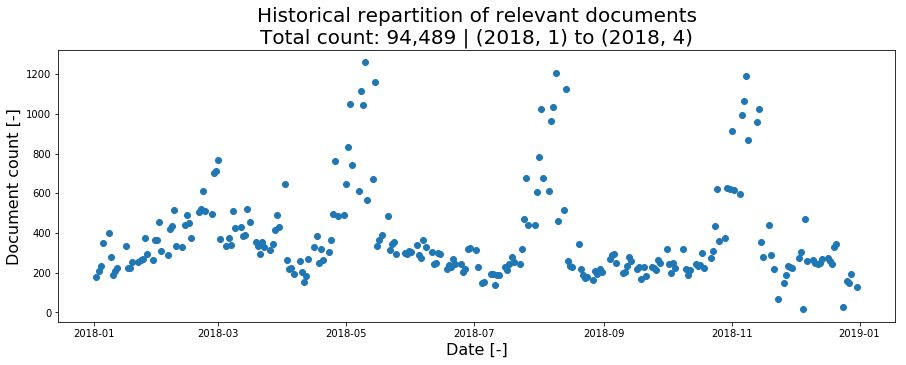

In [21]:
"""Display how many documents are available for that time period"""
# Do some stats on the document dates as a sanity check
# Calculate the number of documents per date
stats = {}
for key in general_url:
    for entry in general_url[key]:
        datetime_date = datetime.strptime(entry[0], '%Y%m%d')
        try:
            stats[datetime_date] += 1
        except:
            stats[datetime_date] = 1

assert sum(stats.values()) == sum(nb_url.values())


# Sort the list for plotting and display
lists = sorted(stats.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(15, 5))
dates = matplotlib.dates.date2num(x)
plt.plot_date(dates, y)
plt.title("Historical repartition of relevant documents\nTotal count: {:,} | {} to {}"
          .format(sum(stats.values()), time_range[0], time_range[1]), fontsize=20)
plt.ylabel('Document count [-]', fontsize=16)
plt.xlabel('Date [-]', fontsize=16)
plt.show()

def is_downloaded(filepath):
    #expected_path = master_url_to_filepath(url_idx)
    if os.path.isfile(filepath):
        return True
    else:  # Build the folder architecture if needed
        if not os.path.isdir(os.path.split(filepath)[0]):
            os.makedirs(os.path.split(filepath)[0])
        return False

In [22]:
def doc_url_to_filepath(submission_date, end_url):
    # entry is a tuple containing the date and the end_url. 
    # The CIK can be found from the end_url
    # The submission ID can be found from there too
    
    cik = end_url.split('/')[2]
    submission_id = "".join(end_url.split('/')[3][:-4].split('-'))
    #print(entry, cik, submission_id)
    return os.path.join(path_daily_data, submission_date, cik, submission_id+'.html')

In [23]:
def doc_url_to_FilingSummary_url(end_url):
    # WARNING: Not all files have a filing summary. 10-Q and 10-K do.
    # Convert a document url to the url of its xml summary
    cik_folder = end_url.split('/')[:3]
    submission_id = "".join(end_url.split('/')[3][:-4].split('-'))
    final_url = "/".join([base_url.rstrip('/'), *cik_folder, submission_id, 'FilingSummary.xml'])
    return final_url

In [24]:
# Generate the list of local path
general_path = {key: [] for key in doc_types}
for file_type in doc_types:
    for entry in tqdm(general_url[file_type]):
        general_path[file_type].append(doc_url_to_filepath(*entry))
    assert len(general_path[file_type]) == len(general_url[file_type])

max_display = 10
print("[INFO] Displaying {} sample local paths:".format(max_display))
for key in general_path:
    print("\nReport type:", key, "({}/{:,})".format(max_display, nb_url[key]))
    for k in range(max_display//2):
        print(general_path[key][k])
    print("...")
    for k in range(len(general_path[key]) - max_display//2, len(general_path[key])):
        print(general_path[key][k])

100%|██████████| 68181/68181 [00:00<00:00, 394265.00it/s]

[INFO] Displaying 10 sample local paths:

Report type: 10-K (10/7,092)
/home/alex/Desktop/data/daily_data/20180314/1000209/000119312518082402.html
/home/alex/Desktop/data/daily_data/20180221/1000228/000100022818000012.html
/home/alex/Desktop/data/daily_data/20180212/1000229/000100022918000025.html
/home/alex/Desktop/data/daily_data/20180316/1000232/000155837018002201.html
/home/alex/Desktop/data/daily_data/20180316/1000298/000155837018002168.html
...
/home/alex/Desktop/data/daily_data/20181129/933974/000155837018009497.html
/home/alex/Desktop/data/daily_data/20181231/935419/000149315218018121.html
/home/alex/Desktop/data/daily_data/20181221/936395/000093639518000048.html
/home/alex/Desktop/data/daily_data/20181120/936528/000093652818000072.html
/home/alex/Desktop/data/daily_data/20181226/945617/000172186818000768.html

Report type: 10-Q (10/19,216)
/home/alex/Desktop/data/daily_data/20180209/1000045/000119312518037381.html
/home/alex/Desktop/data/daily_data/20180313/1000230/00014377491

In [1]:
def display_download_stats(stats):
    """
    Just a better way to display the downloading stats rather than dumping the dict"""
    text = []
    try:
        if stats['free_space'] < 10*2**30:  # Display text in bold red if less than 10 Gb left
            for key in stats:
                to_append = key + ": {:,}".format(stats[key])
                text.append("{}".format(colored(to_append, 'red', attrs=['bold'])))
        else:
            for key in stats:
                text.append(key + ": {:,}".format(stats[key])) 
    except:  
        for key in stats:
            text.append(key + ": {:,}".format(stats[key]))   
    print("[INFO] " + " | ".join(text))

In [32]:
max_download = np.inf # No more download limits
min_time_between_requests = 0.1  # [s]
download_stats = {
    'bytes_downloaded': 0,
    'nb_url': sum(nb_url.values()),
    'count_downloaded': 0,
    'count_already_downloaded': 0,
    'download_failed': 0,
    'free_space': os.statvfs(project_root).f_frsize * os.statvfs(project_root).f_bavail
}  # Number of files, bytes

# Reset any log file that could exist
try:
    os.remove(path_error_log)
except FileNotFoundError:
    pass

last_request = 0  # Initialize this timer
for file_type in doc_types:
    counter = 0
    for entry in tqdm(general_url[file_type]):
        if counter < max_download:
            #path_doc_old = doc_url_to_filepath(*entry)  # [TBR]
            path_doc = general_path[file_type][counter]
            #assert path_doc == path_doc_old

            # Check if the file has already been downloaded
            if not is_downloaded(path_doc):
                url_doc = base_url + entry[1]
                elapsed_since_last_requests = time.perf_counter() - last_request
                if elapsed_since_last_requests < min_time_between_requests:
                    print("[WARNING] Will wait for {:.3f} s"
                          .format(min_time_between_requests - elapsed_since_last_requests))
                    time.sleep(min_time_between_requests - elapsed_since_last_requests)
                if verbose:
                    print("[INFO] Time since last request: {:.3f} s".format(elapsed_since_last_requests))
                last_request = time.perf_counter()
                try:
                    dt_string = datetime.now().strftime("%Y%m%d_%H:%M:%S")
                    print("[INFO] {} request sent".format(dt_string))
                    (filename, headers) = urllib.request.urlretrieve(url_doc, path_doc)
                except:
                    dt_string = datetime.now().strftime("%Y%m%d_%H:%M:%S")
                    error_message = "[ERROR] [{}] URL {} could not be downloaded".format(dt_string, url_doc)
                    with open(path_error_log, 'a') as f:# Send to error log
                        f.write(error_message + "\n")  
                    print(error_message)  # For user is terminal is connected
                    download_stats['download_failed'] += 1
                    continue

                download_time = time.perf_counter() - last_request
                #print((filename, headers))
                downloaded_size = os.path.getsize(path_doc)
                download_stats['bytes_downloaded'] += downloaded_size
                download_stats['count_downloaded'] += 1
                download_stats['free_space'] = os.statvfs(project_root).f_frsize * os.statvfs(project_root).f_bavail
                print("[INFO] [{}] Latest download speed: {:,} kb in {:.3f} s ({:,.1f} kb/s)"
                      .format(file_type, downloaded_size//2**10, download_time, downloaded_size/(2**10*download_time)))
                display_download_stats(download_stats)
            else:
                download_stats['count_already_downloaded'] += 1
                if verbose:
                    print("[WARNING] Document at {} already downloaded".format(path_doc))

            # After each url has been processes, overwrite the log
            with open(path_download_status_log, 'w') as g:
                g.write("Working on: {}\n".format(time_range))
                g.write("{}\n".format(download_stats))
        else:
            break
        counter += 1





  0%|          | 0/7092 [00:00<?, ?it/s]

[INFO] 20190913_11:56:09 request sent






  1%|          | 60/7092 [01:40<3:17:05,  1.68s/it]

[INFO] [10-K] Latest download speed: 39,370 kb in 100.878 s (390.3 kb/s)
[INFO] bytes_downloaded: 40,315,488 | nb_url: 94,489 | count_downloaded: 1 | count_already_downloaded: 59 | download_failed: 0 | free_space: 105,696,911,360
[INFO] 20190913_11:57:50 request sent






  1%|          | 61/7092 [02:21<26:11:25, 13.41s/it]

[INFO] [10-K] Latest download speed: 1,680 kb in 40.772 s (41.2 kb/s)
[INFO] bytes_downloaded: 42,036,338 | nb_url: 94,489 | count_downloaded: 2 | count_already_downloaded: 59 | download_failed: 0 | free_space: 105,690,292,224
[INFO] 20190913_11:58:30 request sent






  1%|          | 62/7092 [02:52<36:28:41, 18.68s/it]

[INFO] [10-K] Latest download speed: 9,929 kb in 30.968 s (320.6 kb/s)
[INFO] bytes_downloaded: 52,204,269 | nb_url: 94,489 | count_downloaded: 3 | count_already_downloaded: 59 | download_failed: 0 | free_space: 105,672,830,976
[INFO] 20190913_11:59:01 request sent






  1%|          | 63/7092 [09:45<267:12:13, 136.85s/it]

[INFO] [10-K] Latest download speed: 27,290 kb in 412.580 s (66.1 kb/s)
[INFO] bytes_downloaded: 80,149,498 | nb_url: 94,489 | count_downloaded: 4 | count_already_downloaded: 59 | download_failed: 0 | free_space: 105,645,076,480
[INFO] 20190913_12:05:54 request sent






  1%|          | 64/7092 [09:48<189:00:21, 96.82s/it] 

[INFO] [10-K] Latest download speed: 14,719 kb in 3.393 s (4,338.5 kb/s)
[INFO] bytes_downloaded: 95,222,113 | nb_url: 94,489 | count_downloaded: 5 | count_already_downloaded: 59 | download_failed: 0 | free_space: 105,629,999,104
[INFO] 20190913_12:05:57 request sent






  1%|          | 65/7092 [11:34<194:30:38, 99.65s/it]

[INFO] [10-K] Latest download speed: 10,204 kb in 106.259 s (96.0 kb/s)
[INFO] bytes_downloaded: 105,671,595 | nb_url: 94,489 | count_downloaded: 6 | count_already_downloaded: 59 | download_failed: 0 | free_space: 105,619,542,016
[INFO] 20190913_12:07:44 request sent






  1%|          | 66/7092 [11:44<142:00:22, 72.76s/it]

[ERROR] [20190913_12:07:54] URL https://www.sec.gov/Archives/edgar/data/1012771/0001012771-18-000006.txt could not be downloaded


AssertionError: 

## Parse a doc and run it through the NLP

### Parse a doc with Vader

In [ ]:
analyser = SentimentIntensityAnalyzer()

for file_type in doc_types:
    counter = 0
    for entry in tqdm(general_path[file_type]):
        # print(entry)
        if counter < max_download:
            t0 = time.perf_counter()
            with open(entry) as f:  # Load the file
                html_doc = f.read()
            soup = BeautifulSoup(html_doc, 'html.parser')
            
            text_only = soup.get_text()
            t1 = time.perf_counter()
            print("Before: {:,} byte | After: {:,} byte | Done in: {:.1f} s"
                  .format(len(html_doc), len(text_only), t1-t0))

            # Get a few subset of the text for analysis
            average_score = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
            length_subset = 10000
            iterations = 100
            
            for _ in range(iterations):
                if len(text_only) > length_subset:
                    start_index = np.random.randint(len(text_only)-length_subset)
                    score = analyser.polarity_scores(text_only[start_index:start_index+length_subset])
                else:
                    score = analyser.polarity_scores(text_only)
                for key in average_score:
                    average_score[key] += score[key]

            for key in average_score:
                    average_score[key] /= iterations
            t2 = time.perf_counter()
            print(average_score)
            """
            print("Took {:.3f} s to analyze {} byte ({} byte/s) | Result: {}"
                  .format(t2-t1, length_subset*iterations, length_subset*iterations/(t2-t1), average_score))
            """
        else:
            break
        counter += 1